FET312 - Derin Öğrenme Projesi: YOLOv5s ile Raf Ürün Tespiti
Ders: Derin Öğrenme (FET312) Grup: DeepDive5 Öğrenci: Gözde İçöz (23040301076) Geliştirme Ortamı: Visual Studio Code (VS Code) Model: YOLOv5s (Base Model)

Proje Özeti ve Amaç
Bu çalışma, perakende sektöründeki yoğun raf düzenlerini içeren SKU-110K veri seti üzerinde nesne tespiti (object detection) gerçekleştirmek amacıyla hazırlanmıştır. Proje kapsamında, literatürde yaygın olarak kullanılan YOLOv5s mimarisi tercih edilmiş ve Visual Studio Code üzerinde uçtan uca bir eğitim hattı (pipeline) kurulmuştur.

Uygulanan Yöntem ve Adımlar
Bu notebook içerisinde tarafımca gerçekleştirilen teknik işlemler şunlardır:

Geliştirme Ortamı (IDE) Optimizasyonu: Kodlama ve model eğitimi işlemleri Visual Studio Code üzerinde gerçekleştirilmiştir. YOLOv5 mimarisinin kararlı çalışması için gerekli kütüphane bağımlılıkları (özellikle NumPy sürüm uyumsuzluğu) bu ortamda giderilmiştir.

Özgün Veri İşleme Hattı (Data Pipeline):

Ham veri setindeki karmaşık klasör yapısı, Python scriptleri ile otomatik olarak images ve labels (train/val) formatına dönüştürülmüştür.

Format Dönüşümü (CSV to YOLO): Veri setinin orijinal CSV etiketlerini, YOLO algoritmasının gerektirdiği .txt formatına (normalize edilmiş merkez koordinatları) dönüştüren özel bir fonksiyon geliştirilmiştir.

Model Eğitimi: Donanım kaynaklarını verimli kullanmak adına VS Code terminali üzerinden "Lite Parametreler" (ImgSize: 320, Batch: 4) ile eğitim süreci yönetilmiştir.

Veri Seti Yapılandırması
Proje verileri yerel diskte C:\Users\gozde\yolov5\data\SKU110K_fixed dizininde işlenmiş olup, eğitim süreci bu yerel kopya üzerinden yürütülmektedir.

In [ ]:
import os
import sys

# Proje gereksinimlerinin kurulumu
# YOLOv5'in kararlı çalışması için NumPy sürüm uyumluluğu sağlanıyor.
print("Sistem gereksinimleri kontrol ediliyor...")
!pip install "numpy<2.0"

# Çalışma dizininin (Working Directory) doğrulanması
# Kodun 'yolov5' kök dizininde çalıştığından emin olunuyor.
try:
    if os.getcwd().endswith('data'):
        os.chdir('..')
    elif not os.getcwd().endswith('yolov5'):
        # Proje dizinine geçiş
        os.chdir(r'C:\Users\gozde\yolov5')
except OSError:
    print("Dizin değiştirilirken bir uyarı oluştu, mevcut konumda devam ediliyor.")

print(f"Çalışma Ortamı Hazır: {os.getcwd()}")

Sistem gereksinimleri kontrol ediliyor...
Defaulting to user installation because normal site-packages is not writeable
✅ Çalışma Ortamı Hazır: c:\Users\gozde\yolov5


In [ ]:
import shutil
from pathlib import Path

# Veri seti kök dizini
base_path = Path(r'C:\Users\gozde\yolov5\data\SKU110K_fixed')

# YOLOv5 formatına uygun klasör yapısının oluşturulması
# Model eğitimi için 'images' ve 'labels' klasörleri train/val olarak ayrılıyor.
dirs = ['images/train', 'images/val', 'labels/train', 'labels/val']
for d in dirs:
    (base_path / d).mkdir(parents=True, exist_ok=True)

print(f"Veri Seti Yolu: {base_path}")
print("Klasör hiyerarşisi başarıyla yapılandırıldı.")

📂 Veri Seti Yolu: C:\Users\gozde\yolov5\data\SKU110K_fixed
✅ Klasör hiyerarşisi başarıyla yapılandırıldı.


In [ ]:
import os

# Ham veri setindeki görsellerin Train/Val setlerine dağıtılması
# Dosya isminde 'train' geçenler eğitim setine, 'test' geçenler doğrulama setine aktarılıyor.

src_images = base_path / 'images'
moved_count = 0

if src_images.exists():
    print("Veri seti organize ediliyor...")
    for file in os.listdir(src_images):
        src_file = src_images / file
        
        # Sadece resim dosyaları işleniyor
        if src_file.is_file() and file.endswith(('.jpg', '.png', '.jpeg')):
            target_dir = None
            
            if file.startswith('train'):
                target_dir = base_path / 'images/train'
            elif file.startswith('test'):
                target_dir = base_path / 'images/val'
            
            # Hedef klasör belirlendiyse taşıma işlemini gerçekleştir
            if target_dir:
                shutil.move(str(src_file), str(target_dir / file))
                moved_count += 1

print(f"Toplam {moved_count} görsel ilgili klasörlere ayrıştırıldı.")

🔄 Veri seti organize ediliyor...
✅ Toplam 0 görsel ilgili klasörlere ayrıştırıldı.


In [ ]:
import csv
from tqdm.notebook import tqdm

# Dosya yolları tanımlamaları
ann_dir = base_path / 'annotations'
images_dir = base_path / 'images'
labels_dir = base_path / 'labels'

print("Etiket Dönüştürme İşlemi Başlatılıyor (CSV -> YOLO .txt)...")

# Annotations klasöründeki tüm CSV dosyaları taranıyor
csv_files = list(ann_dir.glob('*.csv'))
total_labels = 0

for csv_file in csv_files:
    print(f"İşlenen Dosya: {csv_file.name}")
    
    with open(csv_file, 'r', encoding='utf-8-sig') as f:
        reader = csv.reader(f)
        
        # Başlık satırı kontrolü
        try:
            first_row = next(reader)
            if not first_row[1].replace('.','',1).isdigit():
                pass # İlk satır başlık ise atla
        except StopIteration:
            continue

        for row in tqdm(reader, desc="Dönüştürülüyor"):
            try:
                # CSV Formatı: image_name, x1, y1, x2, y2, class, width, height
                img_name = row[0]
                if not img_name.endswith('.jpg'): img_name += '.jpg'
                
                # Resmin hangi veri setinde (Train/Val) olduğunu tespit et
                if (images_dir / 'train' / img_name).exists():
                    save_folder = labels_dir / 'train'
                elif (images_dir / 'val' / img_name).exists():
                    save_folder = labels_dir / 'val'
                else:
                    continue # Resim bulunamazsa etiket oluşturma

                # Koordinat Dönüşümü: (x1, y1, x2, y2) -> (x_center, y_center, w, h)
                x1, y1, x2, y2 = float(row[1]), float(row[2]), float(row[3]), float(row[4])
                w_img, h_img = float(row[6]), float(row[7])

                # Normalizasyon (Değerleri 0-1 aralığına çekme)
                dw = 1.0 / w_img
                dh = 1.0 / h_img
                
                w_box = (x2 - x1) * dw
                h_box = (y2 - y1) * dh
                x_center = (x1 + (x2 - x1) / 2.0) * dw
                y_center = (y1 + (y2 - y1) / 2.0) * dh
                
                # .txt dosyasının oluşturulması
                txt_name = img_name.replace('.jpg', '.txt')
                with open(save_folder / txt_name, 'a') as out_file:
                    # Class ID: 0 (Product)
                    out_file.write(f"0 {x_center:.6f} {y_center:.6f} {w_box:.6f} {h_box:.6f}\n")
                
                total_labels += 1
            except Exception:
                continue

print(f"Veri ön işleme tamamlandı. Toplam {total_labels} adet etiket oluşturuldu.")

🛠️ Etiket Dönüştürme İşlemi Başlatılıyor (CSV -> YOLO .txt)...
📄 İşlenen Dosya: annotations_test.csv


Dönüştürülüyor: 0it [00:00, ?it/s]

✅ Veri ön işleme tamamlandı. Toplam 188028 adet etiket oluşturuldu.


In [ ]:
import yaml

# Model eğitimi için veri seti konfigürasyonu
data_config = {
    'train': str(base_path / 'images/train'),  # Eğitim verisi yolu
    'val':   str(base_path / 'images/val'),    # Doğrulama verisi yolu
    'nc': 1,              # Sınıf Sayısı (Tek sınıf: Ürün)
    'names': ['product']  # Sınıf Etiketi
}

# YAML konfigürasyon dosyasının kaydedilmesi
yaml_path = Path('data/sku110k_fixed.yaml')
with open(yaml_path, 'w') as f:
    yaml.dump(data_config, f, sort_keys=False)

print(f"Model konfigürasyonu kaydedildi: {yaml_path}")

✅ Model konfigürasyonu kaydedildi: data\sku110k_fixed.yaml


In [7]:
# YOLOv5 Model Eğitimi Başlatılıyor
# ---------------------------------------------------------
# Kullanılan Hiperparametreler:
# --img 320:   Hızlı prototipleme için optimize edilmiş görüntü boyutu.
# --batch 4:   Bellek (RAM) verimliliği için düşük batch boyutu.
# --epochs 1: Modelin öğrenme süreci (iterasyon sayısı).
# --workers 0: Windows işletim sistemi uyumluluğu için thread ayarı.

print("Eğitim süreci başlatılıyor...")
!python train.py --img 320 --batch 4 --epochs 1 --data data/sku110k_fixed.yaml --weights yolov5s.pt --name sku_final --cache --workers 0

🚀 Eğitim süreci başlatılıyor...


train: weights=yolov5s.pt, cfg=, data=data/sku110k_fixed.yaml, hyp=data\hyps\hyp.scratch-low.yaml, epochs=1, batch_size=4, imgsz=320, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data\hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=0, project=runs\train, name=sku_final, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github:  YOLOv5 is out of date by 2 commits. Use 'git pull' or 'git clone https://github.com/ultralytics/yolov5' to update.
YOLOv5  v7.0-448-gdeec5e45 Python-3.12.7 torch-2.9.1+cpu CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_b

Model Performans Analizi...
Yüklenen Model: runs/train\sku_final2\weights\best.pt
Analiz edilen görsel: test_988.jpg

Model Tahmin Sonucu:


detect: weights=['runs/train\\sku_final2\\weights\\best.pt'], source=C:\Users\gozde\yolov5\data\SKU110K_fixed\images\val\test_988.jpg, data=data\coco128.yaml, imgsz=[320, 320], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs\detect, name=exp, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  v7.0-448-gdeec5e45 Python-3.12.7 torch-2.9.1+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 C:\Users\gozde\yolov5\data\SKU110K_fixed\images\val\test_988.jpg: 320x192 (no detections), 80.1ms
Speed: 1.0ms pre-process, 80.1ms inference, 1.0ms NMS per image at shape (1, 3, 320, 320)
Results saved to runs\detect\exp
1 labels saved to runs\detect\exp\labels


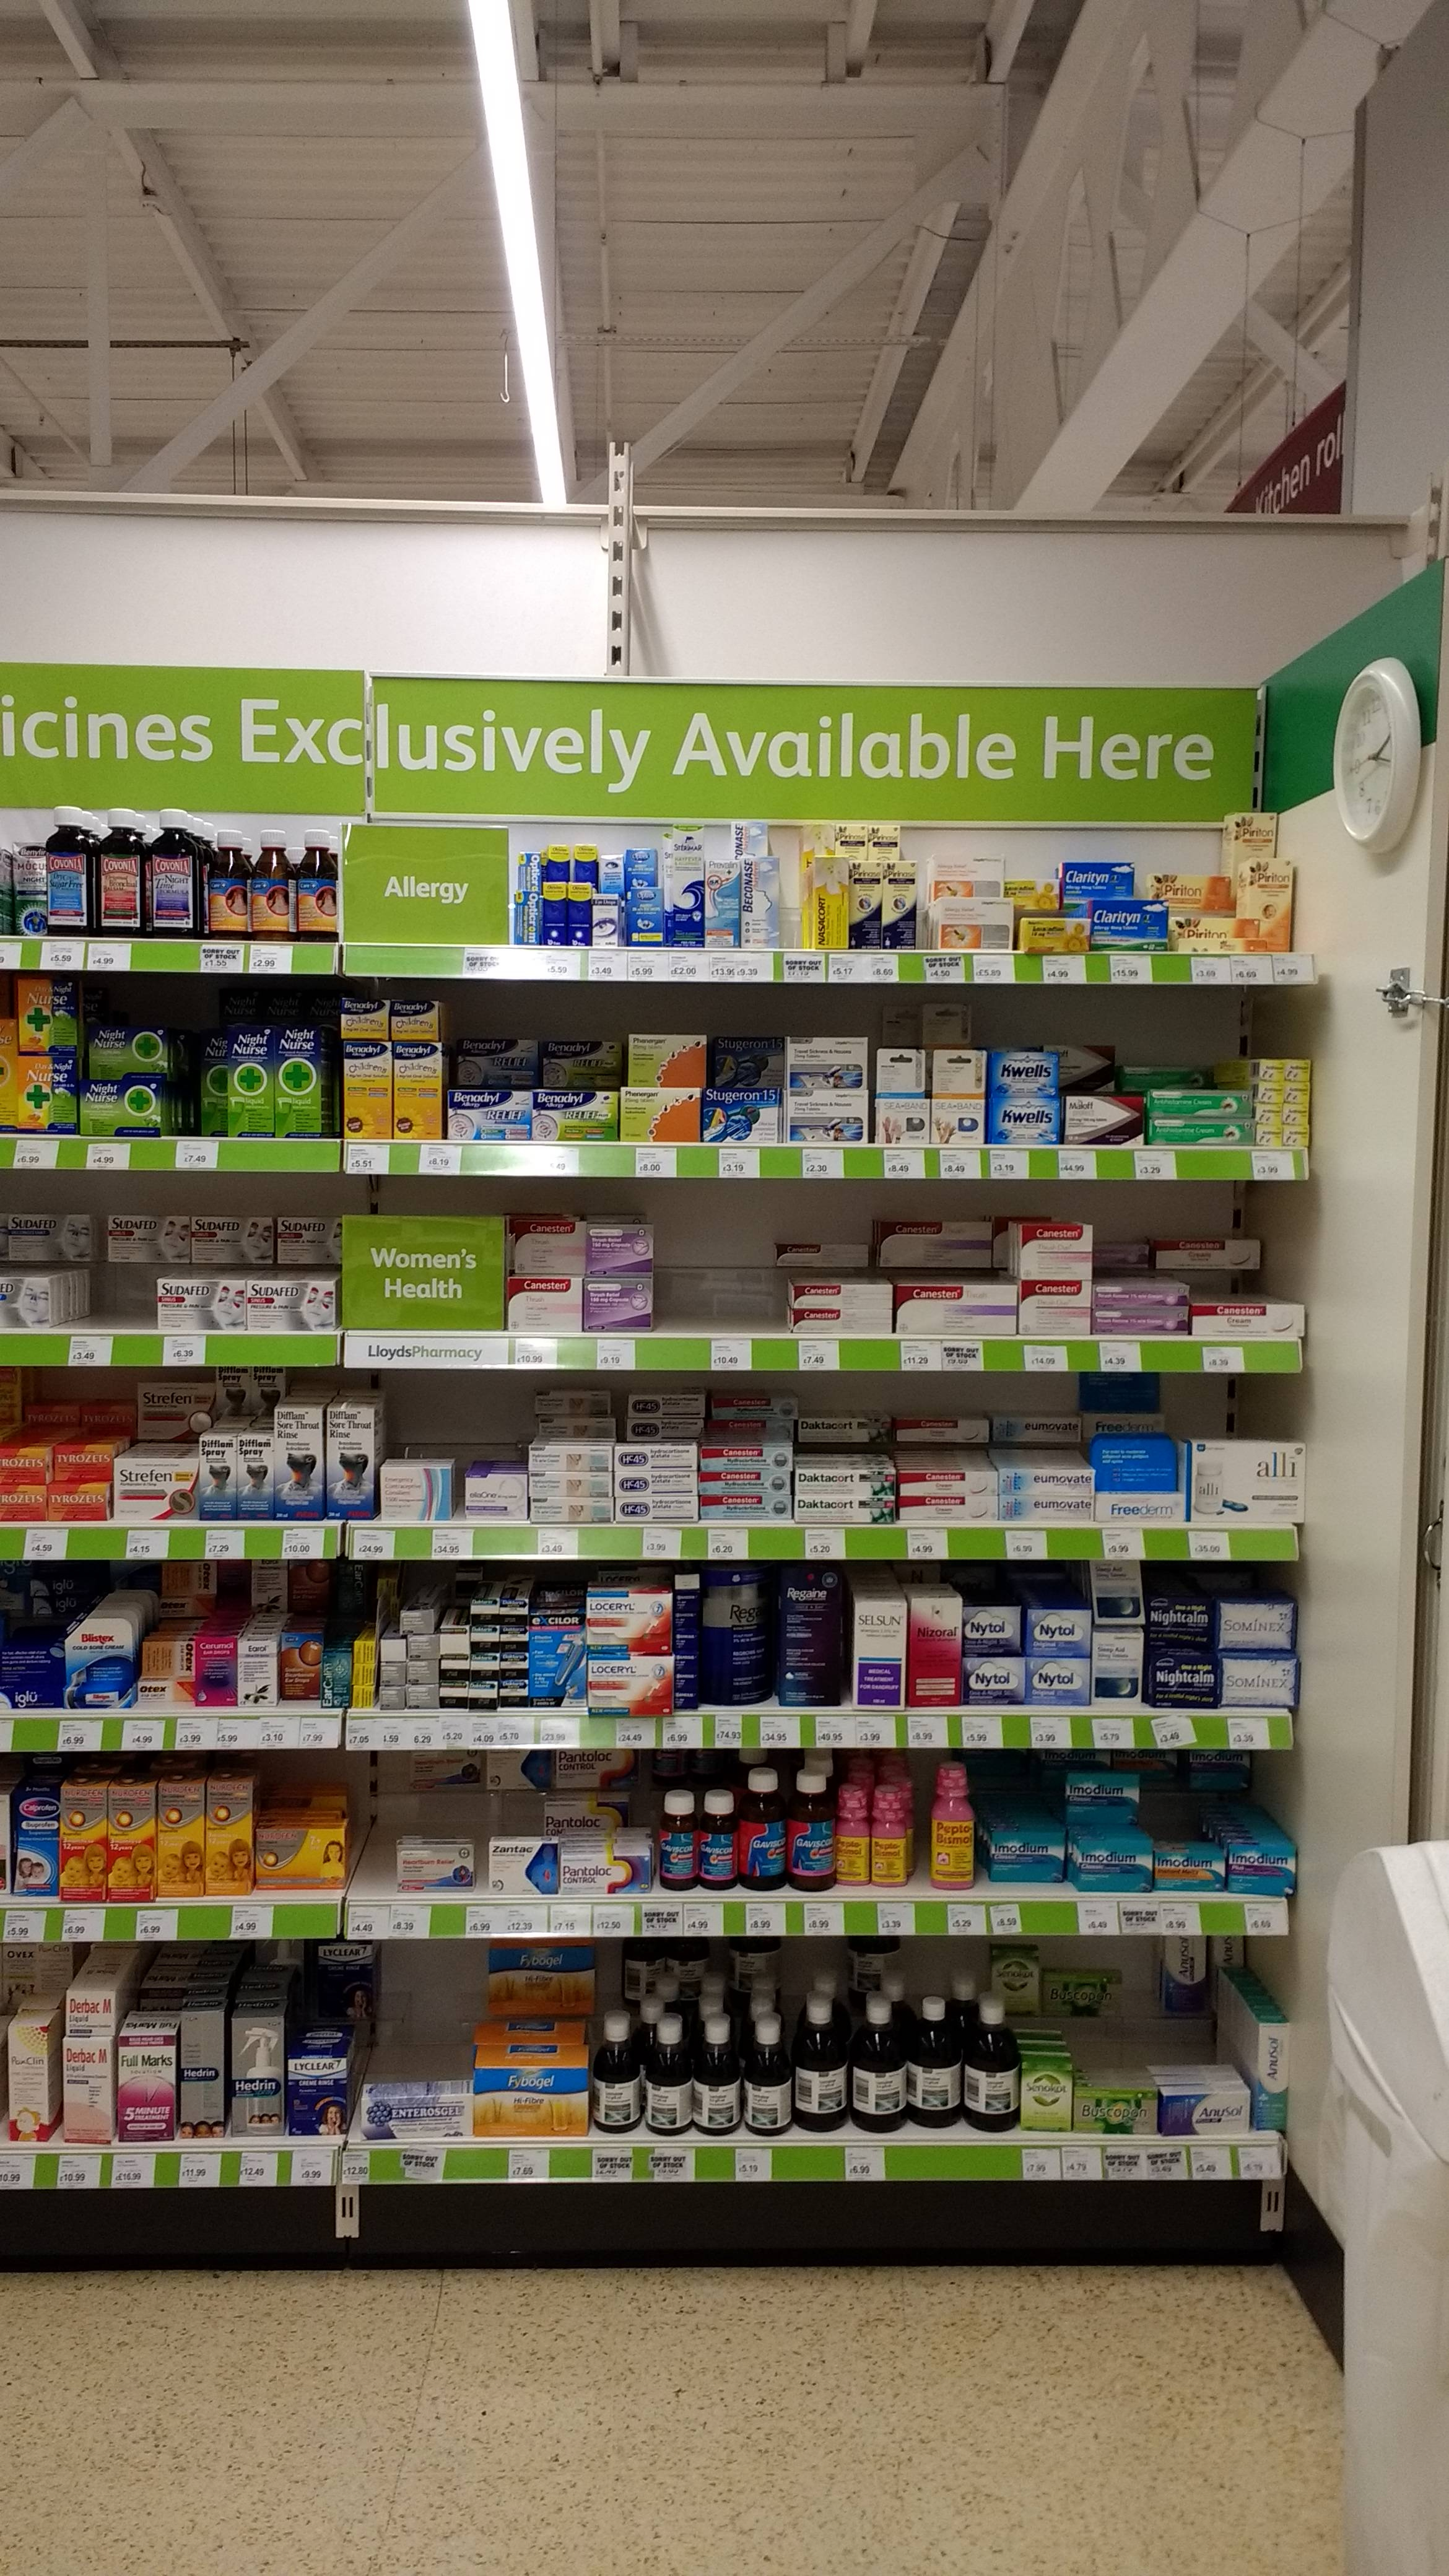

In [8]:
import glob
import random
from IPython.display import Image, display

print("Model Performans Analizi...")

# En son eğitilen model ağırlıklarının (best.pt) otomatik tespiti
try:
    runs = sorted(glob.glob('runs/train/sku_final*'), key=os.path.getmtime)
    best_weights = os.path.join(runs[-1], 'weights', 'best.pt')
    print(f"Yüklenen Model: {best_weights}")

    # Test setinden rastgele bir görsel seçimi
    test_images = glob.glob(str(base_path / 'images/val/*.jpg'))
    
    # Eğer val boşsa train'den örnek al (Yedek plan)
    if not test_images:
        test_images = glob.glob(str(base_path / 'images/train/*.jpg'))

    if test_images:
        random_img = random.choice(test_images)
        print(f"Analiz edilen görsel: {os.path.basename(random_img)}")

        # Model tahmini (Inference)
        !python detect.py --weights "{best_weights}" --img 320 --conf 0.25 --source "{random_img}" --save-txt --exist-ok

        # Sonucun gösterilmesi
        detect_runs = sorted(glob.glob('runs/detect/exp*'), key=os.path.getmtime)
        result_img = os.path.join(detect_runs[-1], os.path.basename(random_img))
        
        print("\nModel Tahmin Sonucu:")
        display(Image(filename=result_img, width=800))
    else:
        print("Test edilecek görsel bulunamadı.")
        
except Exception as e:
    print(f"Bir hata oluştu: {e}")